In [166]:
import scipy.io as io
import scipy.sparse.csgraph as csgraph

import jax
from jax import jit, vmap, random, grad
from jax.experimental import optimizers
from jax import numpy as jnp

from functools import partial
import itertools

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import datetime
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# load the data from the SuiteSparse Matrix Collection format
#   https://www.cise.ufl.edu/research/sparse/matrices/
graph_name = 'qh882'
mat_data = io.loadmat(graph_name + '.mat')
graph = mat_data['Problem']['A'][0][0]
graph

<882x882 sparse matrix of type '<class 'numpy.float64'>'
	with 3354 stored elements in Compressed Sparse Column format>

In [168]:
# find the shortest paths using dijkstra's
# note: if any path length is infinite i.e. we have disconnected subgraphs,
#       then this cell will work but the rest of the script won't.
d = csgraph.shortest_path(graph, directed=False, unweighted=True)

/home/orange3xchicken/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Graph has negative weights: dijkstra will give inaccurate results if the graph contains negative cycles. Consider johnson or bellman_ford.
  after removing the cwd from sys.path.


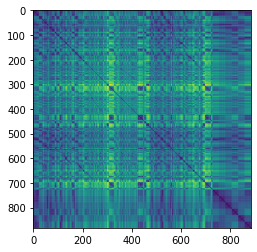

In [169]:
# show the shortest paths in a heat map.
# If any squares are white, then infinite paths exist and the algorithm will fail.
plt.imshow(d)
n = d.shape[0]

In [684]:
seed = 0
# initialise an array of 2D positions
rng = random.PRNGKey(seed)
init_positions = random.normal(rng, (n,2))
opt_init, opt_update, get_params = optimizers.adam(1e-1, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(init_positions)

# weights
eps = 1e-8
w = jnp.square(jnp.reciprocal(d + np.eye(*d.shape)))
w = w - jnp.diag(jnp.diag(w))
l = 0

In [485]:
def pairwise_dist(X):
    euc = lambda x: vmap(lambda y: jnp.linalg.norm(jnp.maximum(jnp.abs(x-y), eps))**2)(X)
    return vmap(euc)(X)

def stress(X, W, D):
    pd = pairwise_dist(X)
    stress = jnp.multiply(W, jnp.square(pd - D))
    return jnp.sum(jnp.triu(stress)) + l*jnp.linalg.norm(X)**2

In [486]:
@jit
def step(i, opt_state, W, D, idx):
    p = get_params(opt_state)
    g = grad(stress)(p[idx], W[jnp.ix_(idx,idx)], D[jnp.ix_(idx,idx)])
    g = jax.ops.index_add(jnp.zeros_like(p), idx, g, 
                          indices_are_sorted=False, unique_indices=True)
    return opt_update(i, g, opt_state)

Text(0.5, 1.0, '96718.57')

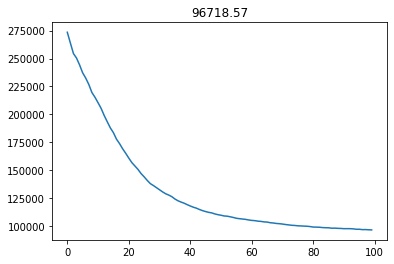

In [173]:
batch_size = 64
num_train = n
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)
itercount = itertools.count()
def data_stream():
    rng = npr.RandomState(seed)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield batch_idx
            
batches = data_stream()

loss = []
for _ in tqdm(range(100)):
    for _ in range(num_batches):
        i = next(itercount)
        idx = next(batches)
        opt_state = step(i, opt_state, w, d, idx)
    
    positions = get_params(opt_state)
    #assert np.all(~np.isnan(positions))
    loss.append(stress(positions, w, d))
        
end = datetime.datetime.now()
plt.plot(loss)
plt.title(stress(positions, w, d))

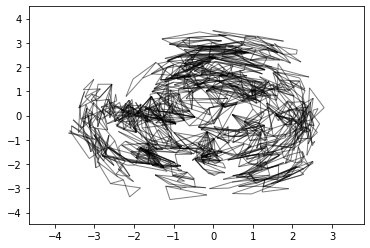

In [174]:
ax = plt.axes()
ax.set_xlim(min(positions[:,0])-1, max(positions[:,0])+1)
ax.set_ylim(min(positions[:,1])-1, max(positions[:,1])+1)

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.5)
ax.add_collection(lc)

plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

In [310]:
def birkhoff_projection(Y, i=100):
    P = Y
    n = Y.shape[0]
    for _ in range(i):
        o = jnp.ones(P.shape[0])
        oo = jnp.outer(o,o)
        P = P + 1/n*(jnp.eye(n) - P + P/n)*oo - 1/n*oo*P
    return P

In [311]:
def cvx_clust_obj(x, pi, K, l):
    K_p = K - jnp.diag(jnp.diag(K))
    return jnp.trace(2*pi.T@K@x - 2*K@x) + \
           2*l*jnp.trace(jnp.diag(jnp.sum(K_p,0))@pi.T@K@x) - \
           2*l*jnp.sum((pi.T@K@x + x.T@K@pi)*K_p)

In [478]:
def cvx_clust_step(x, pi, K, eta, l):
    x = x - eta*grad(cvx_clust_obj)(x, pi, K, l)
    x = jnp.clip(x,-1,1)
    pi = birkhoff_projection(pi + x) 
    return x, pi

In [479]:
ccstep = jit(cvx_clust_step)

In [314]:
# eta stepsize
# l cluster objective weight
def cvx_clust(K, eta=1e-2,l=1e-1):
    pi = jnp.zeros(K.shape)
    x = jnp.zeros(K.shape)
    losses = []
    for _ in tqdm(range(50)):
        x, pi = ccstep(x, pi, K, eta, l)
        losses.append(cvx_clust_obj(x, pi, K))
    return pi, losses

In [315]:
p, losses = cvx_clust(w)

Text(0.5, 1.0, '638 clusters')

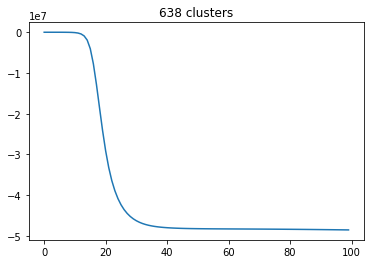

In [320]:
plt.plot(losses)
plt.title('{} clusters'.format(np.unique(jnp.argmax(p,1)).shape[0]))

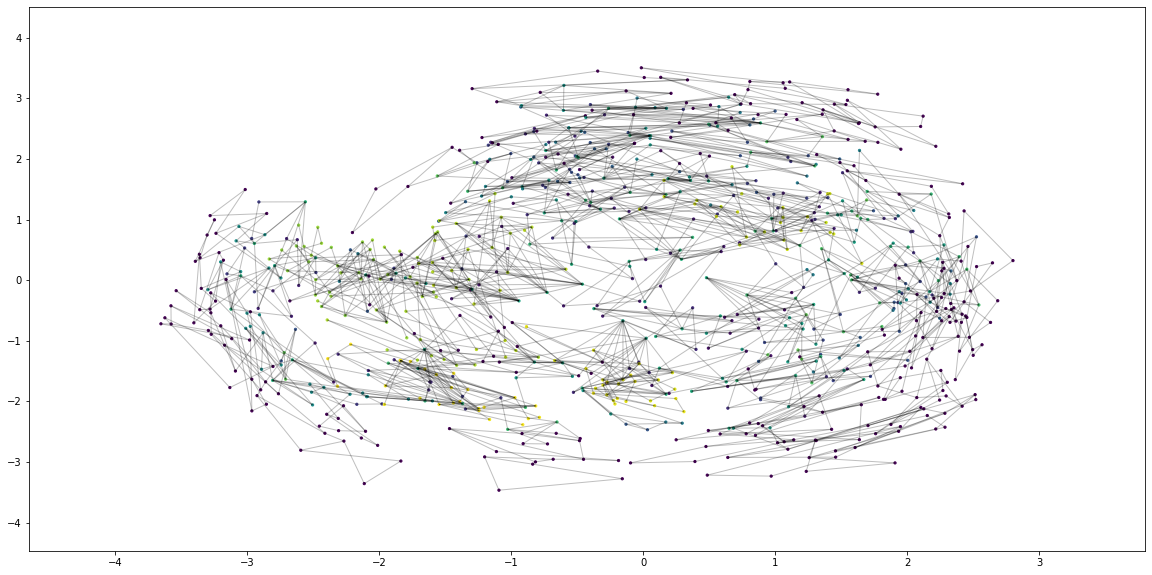

In [334]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_xlim(min(positions[:,0])-1, max(positions[:,0])+1)
ax.set_ylim(min(positions[:,1])-1, max(positions[:,1])+1)

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
ax.add_collection(lc)
ax.scatter(positions[:,0], positions[:,1], s=5, c=jnp.argmax(p,1))
plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

In [531]:
def sparsemax(X):
    number_of_logits = X.shape[-1]
    dim = 1
    # Translate input by max for numerical stability
    #X = X - jnp.repeat(jnp.max(X, axis=dim)[0],X.shape[-1])
    X = X - np.tile(jnp.max(X, axis=1),(X.shape[-1],1)).T
    # Sort input in descending order.
    # (NOTE: Can be replaced with linear time selection method described here:
    # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
    zs = jnp.flip(jnp.sort(X, axis=dim))[0]
    r = jnp.arange(1, number_of_logits + 1, step=1, dtype=float)

    # Determine sparsity of projection
    bound = 1 + r * zs
    cumulative_sum_zs = jnp.cumsum(zs)
    is_gt = jnp.greater(bound, cumulative_sum_zs).astype(float)
    k = jnp.maximum(is_gt * r, dim)[0]

    # Compute threshold function
    zs_sparse = is_gt * zs

    # Compute taus
    taus = (jnp.sum(zs_sparse) - 1) / k
    taus =  np.tile(taus,(X.shape[-1],1)).T
    # Sparsemax
    output = jnp.maximum(jnp.zeros_like(X), X - taus)

    return output

In [532]:
batch_size = 64
num_train = n
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)
def data_stream():
    rng = npr.RandomState(seed)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield batch_idx
            
batches = data_stream()

Text(0.5, 1.0, '91794.36')

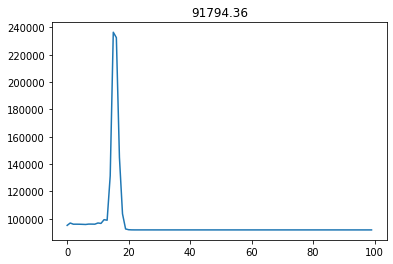

In [534]:
eta=1e-2
l=1e-1
itercount = itertools.count()
K=w
pi = jnp.zeros(K.shape)
x = jnp.zeros(K.shape)
loss = []
for _ in tqdm(range(100)):
    x, pi = ccstep(x, pi, K, eta, l)
    for j in range(K.shape[0]):
        i = next(itercount)
        cluster = jnp.where(pi[:,j] > 0.8)[0]
        if not cluster.shape[0] > 1:
            cluster = next(batches)
        idx = cluster
        opt_state = step(i, opt_state, w, d, idx)
    
    positions = get_params(opt_state)
    #assert np.all(~np.isnan(positions))
    loss.append(stress(positions, w, d))
        
end = datetime.datetime.now()
plt.plot(loss)
plt.title(stress(positions, w, d))

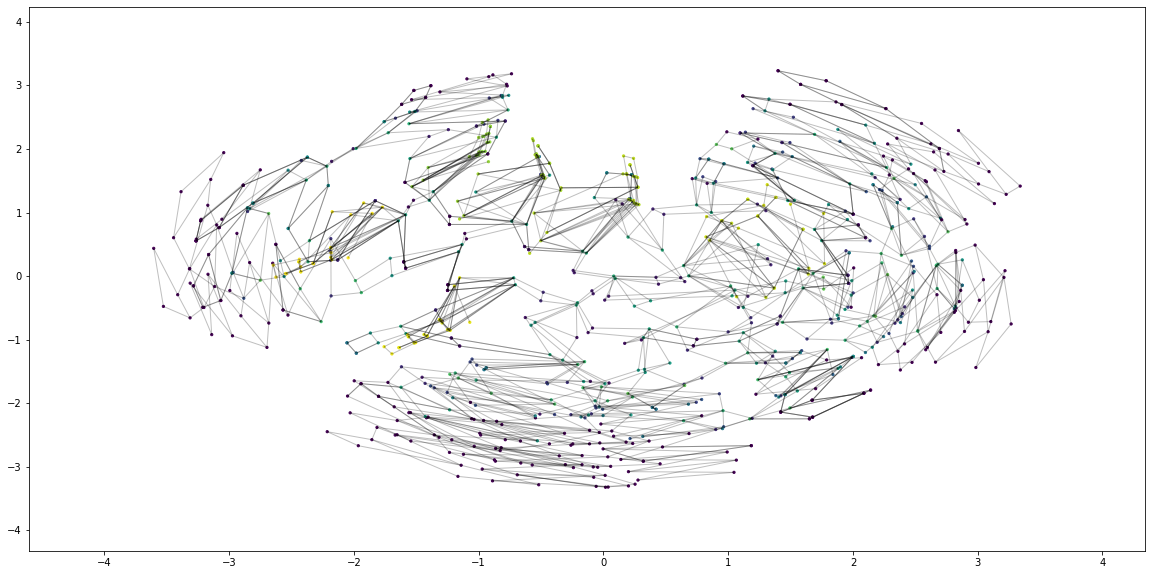

In [535]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_xlim(min(positions[:,0])-1, max(positions[:,0])+1)
ax.set_ylim(min(positions[:,1])-1, max(positions[:,1])+1)

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
ax.add_collection(lc)
ax.scatter(positions[:,0], positions[:,1], s=5, c=jnp.argmax(p,1))
plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

In [ ]:
#https://arxiv.org/pdf/1210.2041.pdf

In [675]:
numedges = jnp.where(w == 1)[0].shape[0]
edgetensor = np.zeros((numedge,)+positions.shape)
edgelist = jnp.where(w == 1)
for i in range(numedges):
    e1 = edgelist[0][i].item()
    e2 = edgelist[1][i].item()
    edgetensor[i,e1,0] = 1
    edgetensor[i,e2,1] = 1
edgetensor = jnp.array(edgetensor)

In [677]:
def _ec(X, U_i, r_i, A_i, B_i):
    return jnp.linalg.norm(jnp.clip(-A_i.T@X@U_i + (r_i + 1)*jnp.ones(U_i.shape[-1]), eps))**2 + \
           jnp.linalg.norm(jnp.clip(-B_i.T@X@U_i - (r_i - 1)*jnp.ones(U_i.shape[-1]), eps))**2
    
def ec_objective(params, A, B):
    X, U, r = params
    return jnp.sum(vmap(partial(_ec,X))(U, r, A, B))

@jit
def ec_step(params, edgetensor, eta):
    X, U, r = params
    g = grad(ec_objective)((X,U, r), edgetensor, edgetensor)
    print(g[0].shape, g[1].shape, g[2].shape)
    X = X - eta*g[0]
    U = U - eta*g[1]
    r = r - eta*g[2]
    return X, U, r

In [672]:
grad(ec_objective)((positions,jnp.ones((numedges,2)), jnp.zeros(numedges)), edgetensor, edgetensor)

(DeviceArray([[-59.398483, -59.398483],
              [-57.173023, -57.173023],
              [-59.39849 , -59.39849 ],
              ...,
              [-55.578773, -55.578773],
              [-78.72063 , -78.72063 ],
              [-76.13103 , -76.13103 ]], dtype=float32),
 DeviceArray([[24.24719   ,  3.5251622 ],
              [20.62265   , -0.49628866],
              [17.573044  ,  3.2366612 ],
              ...,
              [55.512844  , -7.5092664 ],
              [67.69996   , -5.767992  ],
              [62.75222   , -5.2770095 ]], dtype=float32),
 DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [680]:
ec_step((positions,jnp.ones((numedges,2)), jnp.ones(numedges)), edgetensor, 0.01)

(DeviceArray([[-0.65552425,  0.36855692],
              [-0.6747353 ,  0.43598625],
              [-0.6555243 ,  0.3685569 ],
              ...,
              [-2.0908668 ,  0.7287689 ],
              [-1.6385912 ,  0.93297786],
              [-1.675975  ,  1.0264692 ]], dtype=float32),
 DeviceArray([[0.75752807, 0.9647484 ],
              [0.7937735 , 1.0049629 ],
              [0.8242696 , 0.96763337],
              ...,
              [0.44487154, 1.0750927 ],
              [0.3230005 , 1.0576799 ],
              [0.3724778 , 1.0527701 ]], dtype=float32),
 DeviceArray([0.92, 0.92, 0.92, ..., 0.92, 0.92, 0.92], dtype=float32))

Text(0.5, 1.0, '92521.21')

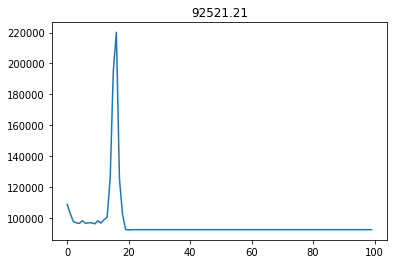

In [685]:
eta=1e-2
l=1e-1
itercount = itertools.count()
K=w
pi = jnp.zeros(K.shape)
x = jnp.zeros(K.shape)
U = jnp.ones((numedges,2))
r = jnp.ones(numedges)
loss = []
for _ in tqdm(range(100)):
    x, pi = ccstep(x, pi, K, eta, l)
    for j in range(K.shape[0]):
        i = next(itercount)
        cluster = jnp.where(pi[:,j] > 0.8)[0]
        if not cluster.shape[0] > 1:
            cluster = next(batches)
        idx = cluster
        opt_state = step(i, opt_state, w, d, idx)
    
    positions = get_params(opt_state)
    positions, U, r = ec_step((positions,jnp.ones((numedges,2)), jnp.ones(numedges)), edgetensor, 0.001)
    #assert np.all(~np.isnan(positions))
    loss.append(stress(positions, w, d))
        
end = datetime.datetime.now()
plt.plot(loss)
plt.title(stress(positions, w, d))

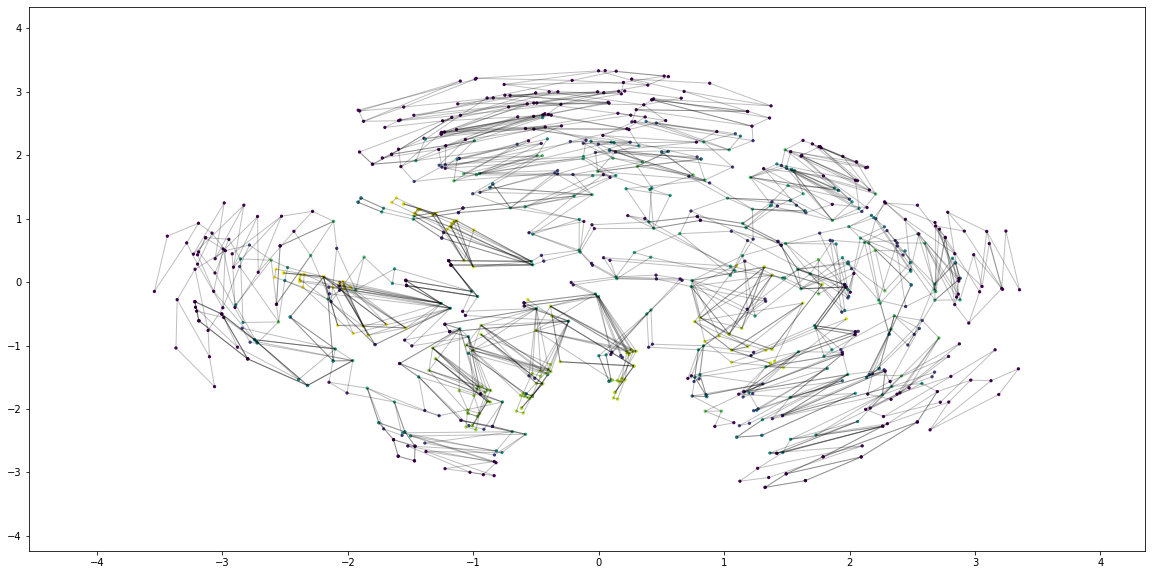

In [686]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_xlim(min(positions[:,0])-1, max(positions[:,0])+1)
ax.set_ylim(min(positions[:,1])-1, max(positions[:,1])+1)

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
ax.add_collection(lc)
ax.scatter(positions[:,0], positions[:,1], s=5, c=jnp.argmax(p,1))
plt.savefig(graph_name + '.svg', format='svg', dpi=1000)